In [1]:
!kaggle datasets download -d datasnaek/mbti-type
!unzip mbti-type.zip
!pip install catboost

Dataset URL: https://www.kaggle.com/datasets/datasnaek/mbti-type
License(s): CC0-1.0
 20% 5.00M/24.4M [00:00<00:01, 15.0MB/s]
100% 24.4M/24.4M [00:00<00:00, 60.4MB/s]
Archive:  mbti-type.zip
  inflating: mbti_1.csv              
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.8 MB/s eta 0:00:00


In [2]:
import re
import string
import pickle
import collections
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings


nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Printing some statistics:**

<Figure size 640x480 with 0 Axes>

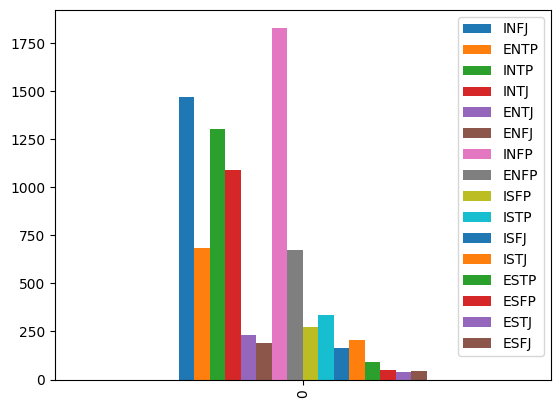

In [3]:
data = pd.read_csv("mbti_1.csv")

mbti_map = {
    "ISTJ": 0,
    "ISFJ": 1,
    "INFJ": 2,
    "INTJ": 3,
    "ISTP": 4,
    "ISFP": 5,
    "INFP": 6,
    "INTP": 7,
    "ESTP": 8,
    "ESFP": 9,
    "ENFP": 10,
    "ENTP": 11,
    "ESTJ": 12,
    "ESFJ": 13,
    "ENFJ": 14,
    "ENTJ": 15,
}

reverse_mbti_map = dict(zip(mbti_map.keys(), mbti_map.values()))

counts = collections.defaultdict(int)
for row in data["type"]:
    counts[row] += 1

counts = dict(counts)
for key, value in counts.items():
    counts[key] = [value]


plotdata = pd.DataFrame(counts)
plt.figure();
plotdata.plot.bar();

**Applying text preprocessing, lemmatization and we remove words that are too frequent and rarely encountered:**

In [4]:
def reg_handling(content: str) -> str:
    "preprocessing posts"

    content = re.sub(r"http\S*", " ", content.lower().lstrip("'"))
    content = re.sub(r'\|{3,}', ' N ', content)
    content = content.translate(str.maketrans(' ', ' ', string.punctuation))
    content = re.sub(r'[^A-z]', ' ', content)

    return content


def applying_stemmer(text: str) -> str:
    stemmer = SnowballStemmer('english')
    new_text = [stemmer.stem(word) for word in text.split()]
    return " ".join(new_text)


def applying_lemmatization(text: str) -> str:
    lemmatizer = WordNetLemmatizer()
    lst = text.split()
    lemmatized_lst = [lemmatizer.lemmatize(word) for word in lst]
    return " ".join(lemmatized_lst)


data["posts"] = data["posts"].apply(reg_handling)
data["postl"] = data["posts"]
data["posts"] = data["posts"].apply(applying_stemmer)
data["postl"] = data["postl"].apply(applying_lemmatization)

columns = ["postl", "posts"]


def delete_rare_words(column):
    words = collections.Counter()
    for text in data[column]:
        for word in text.split():
                words[word] += 1

    # delete words if their number of occurrences is less than 20
    new_vocab = set()
    counter_threshold = 20

    for char, cnt in words.items():
        if cnt > counter_threshold:
            new_vocab.add(char)
    return new_vocab

def applying_vocab(text: str, vocab: list[str]) -> str:
    new_text = [word for word in text.split() if word in vocab]
    return " ".join(new_text)

for column in columns:
    new_vocab = delete_rare_words(column)
    data[column] = data[column].apply(applying_vocab, args=(new_vocab,))

In [5]:
data.head()

,type,posts,postl
0,INFJ,and intj moment not top ten play prank n what ...,and intj moment not top ten play prank N what ...
1,ENTP,im find the lack of me in these post veri alar...,im finding the lack of me in these post very N...
2,INTP,good one cours to which i say i know that my b...,good one course to which i say i know thats my...
3,INTJ,dear intp i enjoy our convers the other day es...,dear intp i enjoyed our conversation the other...
4,ENTJ,your fire n that anoth silli misconcept that a...,youre fired N thats another silly misconceptio...


**Encode data["type"] labels to numbers from 0 up to 15:**

In [6]:
def labels_renaming(mbti_type: str) -> int:
    return reverse_mbti_map[mbti_type]

data["type"] = data["type"].apply(labels_renaming)

data.head()

,type,posts,postl
0,2,and intj moment not top ten play prank n what ...,and intj moment not top ten play prank N what ...
1,11,im find the lack of me in these post veri alar...,im finding the lack of me in these post very N...
2,7,good one cours to which i say i know that my b...,good one course to which i say i know thats my...
3,3,dear intp i enjoy our convers the other day es...,dear intp i enjoyed our conversation the other...
4,15,your fire n that anoth silli misconcept that a...,youre fired N thats another silly misconceptio...


**Fitting the vectorizer and model, we'll use tf-idf, xgboost and catboost:**

In [7]:
def trn_tst_splt(column):
    train_x, test_x, train_y, test_y = train_test_split(
        data[column],
        data["type"],
        train_size=0.8,
        random_state=42
    )
    return train_x, test_x, train_y, test_y

def pipelines():
    pipeline_logreg = Pipeline([
        ('tf-idf', TfidfVectorizer(stop_words='english')),
        ('log-reg', LogisticRegression())
    ])

    pipeline_xgboost = Pipeline([
        ('tf-idf', TfidfVectorizer(stop_words='english')),
        (
            'xgboost',
            XGBClassifier(
                max_depth=5,
                n_estimators=50,
                learning_rate=0.1
            )
        )
    ])

    pipeline_catboost = Pipeline([
        ('tf-idf', TfidfVectorizer(stop_words='english')),
        (
            'catboost',
            CatBoostClassifier(
                loss_function='MultiClass',
                eval_metric='MultiClass',
                task_type='GPU',
                verbose=False
            )
        )
    ])
    return pipeline_logreg, pipeline_xgboost, pipeline_catboost


def pipeline_RandForestClassifier():
    pipeline_forest = Pipeline([
            ('tf-idf', TfidfVectorizer(stop_words='english')),
            ('rfc', RandomForestClassifier())
    ])
    return pipeline_forest


@ignore_warnings(category=ConvergenceWarning)
def fitting(train_x, train_y):
    pipeline_logreg, pipeline_xgboost, pipeline_catboost = pipelines()
    pipeline_logreg.fit(train_x, train_y)
    pipeline_xgboost.fit(train_x, train_y)
    pipeline_catboost.fit(train_x, train_y)

    return pipeline_logreg, pipeline_xgboost, pipeline_catboost




**Results:**

In [8]:
for column in columns:

    train_x, test_x, train_y, test_y = trn_tst_splt(column)
    pipeline_logreg, pipeline_xgboost, pipeline_catboost = fitting(train_x, train_y)
    cb = f1_score(test_y, pipeline_catboost.predict(test_x), average="weighted")
    xgb = f1_score(test_y, pipeline_xgboost.predict(test_x), average="weighted")
    logreg = f1_score(test_y, pipeline_logreg.predict(test_x), average="weighted")
    if column == "posts":
        str = "stemming"
    else:
        str = "lemmatization"
    print(f"catboost f1_score({str}): {cb:.3f}")
    print(f"xgboost  f1_score({str}): {xgb:.3f}")
    print(f"logistic regression f1_score({str}): {logreg:.3f}")

catboost f1_score(lemmatization): 0.643
xgboost  f1_score(lemmatization): 0.637
logistic regression f1_score(lemmatization): 0.621
catboost f1_score(stemming): 0.659
xgboost  f1_score(stemming): 0.651
logistic regression f1_score(stemming): 0.633


**Let's try GridSearch on RandomForest:**

In [9]:
RFC = pipeline_RandForestClassifier()
param_grid = {
    'rfc__n_estimators': [100, 150],
    'rfc__max_depth': [5, 10, 15],
    'rfc__min_samples_split': [5, 10]
}
grid_search = GridSearchCV(estimator=RFC, param_grid=param_grid, cv=5, error_score='raise')
train_x, test_x, train_y, test_y = trn_tst_splt("posts")
grid_search.fit(train_x, train_y)
print("Best parameters:", grid_search.best_params_, '\n', "Best score:", grid_search.best_score_)

Best parameters: {'rfc__max_depth': 15, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 150} 
 Best score: 0.4449567723342939


**Saving best model and vocabulary:**

In [10]:
# dumping vocabulary
with open("new_vocab.txt", "w") as outfile:
    outfile.write("\n".join(new_vocab))


# dumping pipeline
filename = 'finalized_model.pkl'
pickle.dump(pipeline_catboost, open(filename, 'wb'))